# Hubble Diagram
In this notebook we are going to fit a cosmological model ($\Lambda$-CDM for the moment) to a set of luminosity distances $D_L$ and redshift $z$ data from simulated gravitational (GW) events. The data is representative of the expected 1-year observatiosn by Einstein Telescope (ET).

For the fit, we will follow the following equation:
$$D_L = (1+z) \frac{c}{H_0} \int^z \frac{dz^\prime}{\sqrt{\Omega_m a^{-3} + \Omega_\Lambda} + \Omega_r a^{-4} + \Omega_k a^{-2}}$$
where $a = 1/(1+z^\prime)$ and we assume $\Omega_r = \Omega_k = 0$.

In [2]:
# read GW data
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

# Constants
c = 299792.458  # km/s
H0 = 70.0 * 1e5 / 3.086e24  # s^-1
KM_TO_MPC = 3.24078e-20  # Conversion factor from km to Mpc

with h5py.File('nsns_population_joan.hdf5', 'r') as table:
    table.keys()
    dl = table['dL'][()]
    z = table['z'][()]

Text(0, 0.5, '$d_L$ (Mpc)')

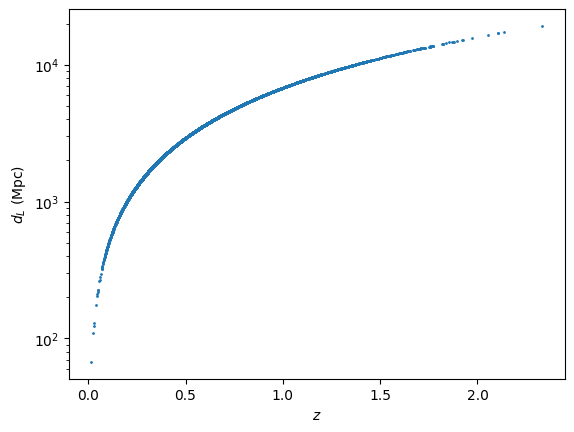

In [5]:
plt.figure()
plt.scatter(z, dl, s=1)
plt.yscale('log'); plt.xlabel(r'$z$'); plt.ylabel(r'$d_L$ (Mpc)')

For the correlation we are going to use a $\chi_r^2$ approach without taking into account the luminosity distance errors.

In [7]:
def fit_luminosity_distance(z, H0, Om, Ode, Or=0.0, Ok=0.0):
    """

    :param z:
    :param H0:
    :param Om:
    :param Ode:
    :param Or:
    :param Ok:
    :return:
    """

    def luminosity_distance_single(z, Ho=H0, O_m=Om, O_DE=Ode):
        def integrand(z_prime):
            return 1.0 / np.sqrt(O_m * (1 + z_prime) ** 3 + O_DE)

        # Create redshift sample array
        z_array = np.linspace(0, z, num=1000)

        # Evaluate integrand on array
        y_values = integrand(z_array)

        # Compute definite integral from 0 to z
        integral = cumulative_trapezoid(y_values, z_array, initial=0)[-1]

        # Compute luminosity distance
        return (c * (1 + z) / Ho) * integral

    # Handle scalar and array inputs
    if np.isscalar(z):
        return luminosity_distance_single(z, H0, Om, Ode)
    else:
        return np.array([luminosity_distance_single(z_i, H0, Om, Ode) for z_i in z])

In [8]:
# Parameter ranges
Om_range = np.linspace(0.1, 2.0, 15)
Ode_range = np.linspace(0.1, 2.0, 15)

# Calculate chi-square surface
chi_surface = np.zeros((len(Om_range), len(Ode_range)))

for i, Om in enumerate(Om_range):
    for j, Ode in enumerate(Ode_range):
        model = fit_luminosity_distance(z, H0, Om, Ode) * KM_TO_MPC
        residuals = dl - model
        chi_surface[i, j] = np.sum(residuals)/(len(dl)-2)

# Find best fit parameters
min_idx = np.unravel_index(np.argmin(chi_surface), chi_surface.shape)
Om_fit, Ode_fit = Om_range[min_idx[0]], Ode_range[min_idx[1]]
print(f"Best fit parameters: Omega_m = {Om_fit:.2f}, Omega_Lambda = {Ode_fit:.2f}")

Best fit parameters: Omega_m = 0.10, Omega_Lambda = 0.10


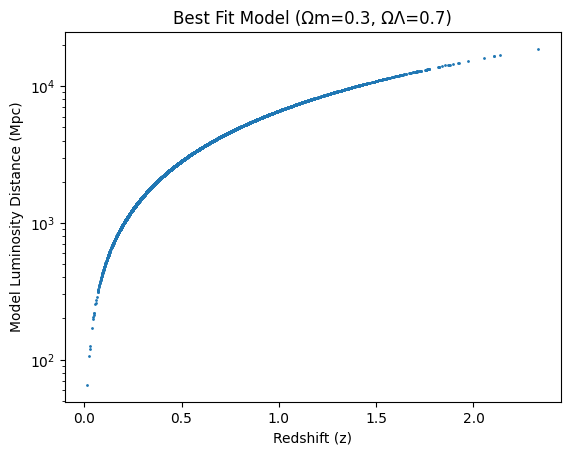

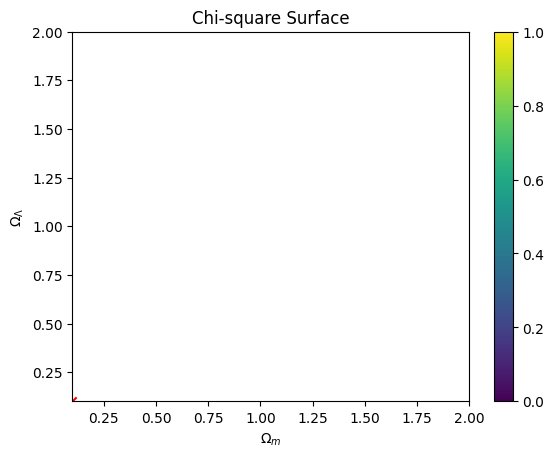

In [11]:
# Plot best fit model
best_fit = fit_luminosity_distance(z, H0, Om_fit, Ode_fit)
plt.scatter(z, model, s=1)
plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Model Luminosity Distance (Mpc)')
plt.title('Best Fit Model (Ωm=0.3, ΩΛ=0.7)')
plt.show()

# Plot contour
plt.contourf(Om_range, Ode_range, chi_surface, levels=[chi_surface[i,j], chi_surface[i,j] + 2.3, chi_surface[i,j] + 4.61, chi_surface[i,j] + 9.21])
plt.scatter(Om_fit, Ode_fit, marker='x', c='r', label=f'Om={Om_fit} Ode={Ode_fit}')
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Chi-square Surface')
plt.colorbar()
plt.show()